In [239]:
import numpy as np
import scipy
import scipy.stats
import scipy.sparse
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import NearestNeighbors
import time
import os
import json
from datetime import datetime
import matplotlib
matplotlib.use('PS')
import matplotlib.pyplot as plt
%matplotlib inline
import scanpy as sc
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
from collections import Counter
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


In [324]:
%load_ext autoreload
%autoreload 2
from xgboost import XGBClassifier

# Load data

In [240]:
data_dir = './Data/'
plot_dir = './Plots/'
data = pd.read_csv(data_dir+'hwf_clean_2020-05-12.csv', dtype=str)
data.shape

(3661716, 186)

# Prepare data

### Subset to v4 survey responses

In [241]:
data = data[data['survey_version']=='4']
data.shape

(1944808, 186)

In [243]:
len(np.unique(data['session_id'][data.covid_19_swab_test_result=='positive']))

570

### Remove responses with problematic 'missing' values (total about 20k)

In [244]:
data.query("race_cat!='missing'",inplace=True)
data.query("number_protective!='missing'",inplace=True)
data.query("combined_stayed_home!='missing'",inplace=True)
data.query("combined_left_for_work!='missing'",inplace=True)
data.query("combined_left_for_other!='missing'",inplace=True)
data.shape

(1916850, 186)

### Implement recoding of all features of interest as binary variables

In [245]:
# ORIGINAL CODING
    # UPDATED CODING

##############    
    
# 'gender': array(['female', 'male', 'other']    ## split other into separate feature
    # 'male': ['False', 'True']
    # 'gender_other': ['False', 'True']

data['male'] = data['gender']=='male'
data['gender_other'] = data['gender']=='other'

# 'age_range_NEW': array(['[18,30)', '[30,45)', '[60,80)', '[45,60)', '[80+)', 'missing']    ## recode as binary
    # 'age_18-29': ['False', 'True']
    # 'age_30-44': ['False', 'True']
    # 'age_45-59': ['False', 'True']
    # 'age_60-79': ['False', 'True']
    # 'age_80+': ['False', 'True']

data['age_18-29'] = data['age_range_NEW']=='[18,30)'
data['age_30-44'] = data['age_range_NEW']=='[30,45)'
data['age_45-59'] = data['age_range_NEW']=='[45,60)'
data['age_60-79'] = data['age_range_NEW']=='[60,80)'
data['age_80+'] = data['age_range_NEW']=='[80+)'
    
# 'race_cat': array(['white', 'hispanic_latino', 'asian', 'african_american', 'multiracial_white', 'other', 'missing']
    # 'race_white': ['False', 'True']
    # 'race_hispanic_latino': ['False', 'True']
    # 'race_asian': ['False', 'True']
    # 'race_african_american': ['False', 'True']
    # 'race_multiracial_white': ['False', 'True']
    # 'race_other': ['False', 'True']
    
data['race_white'] = data['race_cat']=='white'
data['race_hispanic_latino'] = data['race_cat']=='hispanic_latino'
data['race_asian'] = data['race_cat']=='asian'
data['race_african_american'] = data['race_cat']=='african_american'
data['race_multiracial_white'] = data['race_cat']=='multiracial_white'
data['race_other'] = data['race_cat']=='other'

# 'feeling': ['well', 'not_well']    ## recode as binary
    # 'feeling_well': ['False', 'True']

data['feeling_well'] = data['feeling']=='well'    

# 'symptoms_fever_temp_f': [nan, '99.8', '100.8']    ## recode into discrete bins
    # 'symptoms_fever_temp_f_<100': ['False', 'True']
    # 'symptoms_fever_temp_f_100-102': ['False', 'True']
    # 'symptoms_fever_temp_f_102-104': ['False', 'True']
    # 'symptoms_fever_temp_f_>104': ['False', 'True'] 

x = data['symptoms_fever_temp_f'].astype('float')
data['symptoms_fever_temp_f_<100'] = x < 100
data['symptoms_fever_temp_f_100-102'] = (x >= 100) & (x < 102)
data['symptoms_fever_temp_f_102-104'] = (x >= 102) & (x < 104)
data['symptoms_fever_temp_f_>104'] = (x >= 104)

# 'sleep': ['9_to_10_hours', '7_to_8_hours', '5_to_6_hours', 'less_than_5', '11_or_more_hours', 'missing']    ## only 1 'missing'
    # 'sleep_less_than_5': ['False', 'True']
    # 'sleep_5_to_6_hours': ['False', 'True']
    # 'sleep_7_to_8_hours': ['False', 'True']
    # 'sleep_9_to_10_hours': ['False', 'True']
    # 'sleep_11_or_more_hours': ['False', 'True']

data['sleep_less_than_5'] = data['sleep']=='less_than_5'
data['sleep_5_to_6_hours'] = data['sleep']=='5_to_6_hours'
data['sleep_7_to_8_hours'] = data['sleep']=='7_to_8_hours'
data['sleep_9_to_10_hours'] = data['sleep']=='9_to_10_hours'
data['sleep_11_or_more_hours'] = data['sleep']=='11_or_more_hours'

# 'smoking_history': ['used_to_smoke', 'never_smoked', 'currently_smoke']    # recode as binary
    # 'smoking_never': ['False', 'True']
    # 'smoking_ex': ['False', 'True']
    # 'smoking_current': ['False', 'True']
    
data['smoking_never'] = data['smoking_history'] == 'never_smoked'
data['smoking_ex'] = data['smoking_history'] == 'used_to_smoke'
data['smoking_current'] = data['smoking_history'] == 'currently_smoke'

# 'number_preexisting': ['0', '1', '2', '3', '4', '5', nan, '6', '8', '12', '10', '7', '9', '11']    # recode as binary
    # 'number_preexisting_0': ['True', 'False']
    # 'number_preexisting_1': ['True', 'False']
    # 'number_preexisting_2': ['True', 'False']
    # 'number_preexisting_3': ['True', 'False']
    # 'number_preexisting_4+': ['True', 'False']

x = data['number_preexisting'].astype('float')
data['number_preexisting_0'] = data['number_preexisting'] == '0'
data['number_preexisting_1'] = data['number_preexisting'] == '1'
data['number_preexisting_2'] = data['number_preexisting'] == '2'
data['number_preexisting_3'] = data['number_preexisting'] == '3'
data['number_preexisting_4+'] = x >= 4 

# 'household_members_count': ['4', '5', '1', '2', '3', nan]    ## recode as binary bins
    # 'household_members_1': ['False', 'True']
    # 'household_members_2': ['False', 'True']
    # 'household_members_3': ['False', 'True']
    # 'household_members_4': ['False', 'True']
    # 'household_members_5+': ['False', 'True']

data['household_members_1'] = data['household_members_count'] == '1'
data['household_members_2'] = data['household_members_count'] == '2'
data['household_members_3'] = data['household_members_count'] == '3'
data['household_members_4'] = data['household_members_count'] == '4'
data['household_members_5+'] = data['household_members_count'] == '5'

# 'cancelled_medical_appointment': [nan, 'yes', 'no']    ## nan,'no'->False, 'yes'->True
    # 'cancelled_medical_appointment_': ['False', 'True']

data['cancelled_medical_appointment_'] = data['cancelled_medical_appointment'] == 'yes' 
    
# 'protective_measures_face_mask': ['False', 'not_asked', 'True']    ## 'not_asked' applies to those who stayed home, which are marked by a separate feature 'combined_stayed_home', so recode as false here
    # 'protective_measures_face_mask_': ['False', 'True']
    
data['protective_measures_face_mask_'] = data['protective_measures_face_mask'] == 'True'
    
# 'protective_measures_none': ['False', 'not_asked', 'True']
    # 'protective_measures_none_': ['False', 'True']

data['protective_measures_none_'] = data['protective_measures_none'] == 'True'

# 'protective_measures_other_face_covering': ['False', 'not_asked', 'True']
    # 'protective_measures_other_face_covering_': ['False', 'True']

data['protective_measures_other_face_covering_'] = data['protective_measures_other_face_covering'] == 'True'

# 'protective_measures_social_distancing': ['True', 'not_asked', 'False']
    # 'protective_measures_social_distancing_': ['True', 'False']

data['protective_measures_social_distancing_'] = data['protective_measures_social_distancing'] == 'True'

# 'number_protective': ['1', 'not_asked', '2+', '0', 'missing']    ## recode as binary and remove missing (not_asked -> 0 since covered by stayed home as above)
    # 'number_protective_0': ['False', 'True']
    # 'number_protective_1': ['False', 'True']
    # 'number_protective_2+': ['False', 'True']

data['number_protective_0'] = data['number_protective'] == '0'
data['number_protective_1'] = data['number_protective'] == '1'
data['number_protective_2+'] = data['number_protective'] == '2+'

# 'estimate_people_contact_cat': ['2-4', 'missing', '5-9', '20+', '10-19', '1']    ## recode as binary bins
    # 'estimate_people_contact_missing': ['False', 'True']
    # 'estimate_people_contact_1': ['False', 'True']
    # 'estimate_people_contact_2-4': ['False', 'True']
    # 'estimate_people_contact_5-9': ['False', 'True']
    # 'estimate_people_contact_10-19': ['False', 'True']
    # 'estimate_people_contact_20+': ['False', 'True']

data['estimate_people_contact_missing'] = data['estimate_people_contact_cat'] == 'missing'
data['estimate_people_contact_1'] = data['estimate_people_contact_cat'] == '1'
data['estimate_people_contact_2-4'] = data['estimate_people_contact_cat'] == '2-4'
data['estimate_people_contact_5-9'] = data['estimate_people_contact_cat'] == '5-9'
data['estimate_people_contact_10-19'] = data['estimate_people_contact_cat'] == '10-19'
data['estimate_people_contact_20+'] = data['estimate_people_contact_cat'] == '20+'

# 'profession_essential_cat': ['nonessential', 'other_essential', 'healthcare', 'missing']    ## recode as binary
    # 'profession_essential_missing': ['False', 'True']
    # 'profession_essential_nonessential': ['False', 'True']
    # 'profession_essential_healthcare': ['False', 'True']
    # 'profession_essential_other_essential': ['False', 'True']

data['profession_essential_missing'] = data['profession_essential_cat'] == 'missing'
data['profession_essential_nonessential'] = data['profession_essential_cat'] == 'nonessential'
data['profession_essential_healthcare'] = data['profession_essential_cat'] == 'healthcare'
data['profession_essential_other_essential'] = data['profession_essential_cat'] == 'other_essential'

# 'feeling_safe_to_work': ['no', 'missing', 'yes']    ## split missing into separate feature since many responses
    # 'feeling_safe_to_work_missing': ['False', True']
    # 'feeling_safe_to_work': ['no', 'yes']

data['feeling_safe_to_work_missing'] = data['feeling_safe_to_work'] == 'missing'
data['feeling_safe_to_work'] = data['feeling_safe_to_work'] == 'yes'

# 'NEW_number_food_sources': [nan, '2', '1', '3', '4', '5', '6']
    # 'number_food_sources_1': ['True', 'False']
    # 'number_food_sources_2+': ['True', 'False']

x = data['NEW_number_food_sources'].astype('float')
data['number_food_sources_1'] = data['NEW_number_food_sources'] == '1'
data['number_food_sources_2+'] = x >= 2 


### Subset data to users who had a definitive (known result) covid19 test

In [248]:
def get_delta_test_dates(data): # updated 05-12, now compatible with multiple different surveys
    """
    Takes a user slice of data as input and returns the time from each response to the first test of that user. 
    """
    data = data.reset_index()
    
    test_dates = []

    for i, row in data.iterrows():
        if row['survey_version']=='4':
            if type(row['covid_19_swab_test_date'])==str:
                test_dates.append(datetime.strptime(row['covid_19_swab_test_date'], "%Y-%m-%d"))
        else:
            if type(row['covid_19_test_date'])==str:
                test_dates.append(datetime.strptime(row['covid_19_test_date'], "%Y-%m-%d"))
    try:
        first_test = min(test_dates)
    except:
        print(f"Warning: user {data['session_id'].iloc[0]} has no reported test date, using first response date")
        first_test = datetime.strptime(data['date'].iloc[0], "%Y-%m-%d %H:%M:%S")
        
    dates = list(data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")))
    x = [date-first_test for date in dates]
    delta_test_dates = [val.days for val in x]
    
    return delta_test_dates

In [249]:
# Get user IDs who had a definitive covid19 test
#tmp = data.dropna(subset=['covid_19_test_result'])
tmp = data.dropna(subset=['covid_19_swab_test_result'])
#tmp = tmp[tmp.covid_19_test_result.isin(["positive","negative"])]
tmp = tmp[tmp.covid_19_swab_test_result.isin(["positive","negative"])]    # do not use antibody tests
users = np.unique(tmp['session_id']) # 5,216 on 05-07

# Parse dataframe for tested users
tmp = data.set_index('session_id')
covid19_tested = tmp.loc[users]
covid19_tested_grouped = covid19_tested.groupby('session_id')

# Add datafield for days since COVID-19 test + build dictionary of ultimate test result for each user

delta_test_dates = []
test_result_dict = {}
for user, user_data in covid19_tested_grouped:
    delta_test_dates += get_delta_test_dates(user_data)
    #if sum(user_data.covid_19_test_result.isin(['positive']))>0:
    if sum(user_data.covid_19_swab_test_result.isin(['positive']))>0:
        test_result_dict[user] = 'positive'
    #elif sum(user_data.covid_19_test_result.isin(['negative']))>0:
    elif sum(user_data.covid_19_swab_test_result.isin(['negative']))>0:
        test_result_dict[user] = 'negative'
covid19_tested['delta_test_dates'] = delta_test_dates

# NOTE: 4,781 negative users, 440 positive users

# Obtain timewindow of responses from 10 days prior up until 2 weeks after test
a = covid19_tested['delta_test_dates'] > -11
b = covid19_tested['delta_test_dates'] < 15
idx = a&b
covid19_tested = covid19_tested[idx]

### Convert any remaining variables to boolean

In [250]:
covid19_tested.replace(to_replace='nan', value=False, inplace=True, regex=True)
covid19_tested.replace(to_replace='no', value=False, inplace=True, regex=True)
covid19_tested.replace(to_replace='False', value=False, inplace=True, regex=True)
covid19_tested.replace(to_replace='yes', value=True, inplace=True, regex=True)
covid19_tested.replace(to_replace='True', value=True, inplace=True, regex=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


### Specify final predictive feature sets

In [291]:
pred_features_symptoms = [
    'feeling_well',
#    'symptoms_well_none_reported',
    'symptoms_well_chills',
    'symptoms_well_cough',
    'symptoms_well_headache',
    'symptoms_well_loss_of_taste_and_or_smell',
    'symptoms_well_low_grade_fever',
    'symptoms_well_mild_fatigue',
    'symptoms_well_muscle_and_joint_pain',
    'symptoms_well_nasal_congestion',
    'symptoms_well_none',
    'symptoms_well_runny_nose',
    'symptoms_well_tight_feeling_in_chest',
    'not_well_symptoms_abdominal_pain',
    'not_well_symptoms_chills_shaking',
    'not_well_symptoms_diarrhea',
    'not_well_symptoms_dry_cough',
    'not_well_symptoms_facial_numbness',
    'not_well_symptoms_fever',
    'symptoms_fever_temp_f_<100',
    'symptoms_fever_temp_f_100-102',
    'symptoms_fever_temp_f_102-104',
    'symptoms_fever_temp_f_>104',
    'not_well_symptoms_irregular_heartbeat',
    'not_well_symptoms_loss_of_appetite',
    'not_well_symptoms_loss_of_taste_and_or_smell',
    'not_well_symptoms_muscle_and_joint_pain',
    'not_well_symptoms_nasal_congestion',
    'not_well_symptoms_nausea_and_vomiting',
    'not_well_symptoms_runny_nose',
    'not_well_symptoms_shortness_of_breath',
    'not_well_symptoms_sore_throat',
    'not_well_symptoms_tight_feeling_in_chest',
    'not_well_symptoms_tingling_sensation',
    'not_well_symptoms_tinnitus',
    'not_well_symptoms_wet_cough',
#    'not_well_symptoms_none_reported',
    'covid_19_ext_symptoms_abdominal_pain',
    'covid_19_ext_symptoms_chills_shaking',
    'covid_19_ext_symptoms_diarrhea',
    'covid_19_ext_symptoms_dry_cough',
    'covid_19_ext_symptoms_facial_numbness',
    'covid_19_ext_symptoms_fever',
    'covid_19_ext_symptoms_irregular_heartbeat',
    'covid_19_ext_symptoms_loss_of_appetite',
    'covid_19_ext_symptoms_loss_of_smell',
    'covid_19_ext_symptoms_loss_of_taste',
    'covid_19_ext_symptoms_muscle_and_joint_pain',
    'covid_19_ext_symptoms_nasal_congestion',
    'covid_19_ext_symptoms_nausea_and_vomiting',
    'covid_19_ext_symptoms_none',
    'covid_19_ext_symptoms_runny_nose',
    'covid_19_ext_symptoms_shortness_of_breath',
    'covid_19_ext_symptoms_sore_throat',
    'covid_19_ext_symptoms_tight_feeling_in_chest',
    'covid_19_ext_symptoms_tingling_sensation',
    'covid_19_ext_symptoms_tinnitus',
    'covid_19_ext_symptoms_wet_cough']

    
pred_features_non_symptoms = [
    'male',
    'gender_other',
    'age_18-29',
    'age_30-44',
    'age_45-59',
    'age_60-79',
    'age_80+',
    'race_white',
    'race_hispanic_latino',
    'race_asian',
    'race_african_american',
    'race_multiracial_white',
    'race_other',
    'smoking_never',
    'smoking_ex',
    'smoking_current',
    'preexisting_allergies',
    'preexisting_asthma',
    'preexisting_autoimmune_disease',
    'preexisting_cancer',
    'preexisting_cardiovascular_disease',
    'preexisting_chronic_kidney_disease',
    'preexisting_diabetes',
    'preexisting_hypertension',
    'preexisting_immunodeficiency',
    'preexisting_liver_disease',
    'preexisting_not_say',
    'preexisting_pregnant',
    'preexisting_none',
    'preexisting_chronic_lung_disease',
    'number_preexisting_0',
    'number_preexisting_1',
    'number_preexisting_2',
    'number_preexisting_3',
    'number_preexisting_4+',
    'sleep_less_than_5',
    'sleep_5_to_6_hours',
    'sleep_7_to_8_hours',
    'sleep_9_to_10_hours',
    'sleep_11_or_more_hours',
    'profession_essential',
    'profession_essential_missing',
    'profession_essential_nonessential',
    'profession_essential_healthcare',
    'profession_essential_other_essential',
    'feeling_safe_to_work_missing',
    'feeling_safe_to_work',
    'household_members_1',
    'household_members_2',
    'household_members_3',
    'household_members_4',
    'household_members_5+',
    'combined_stayed_home',
    'cancelled_medical_appointment_',
    'combined_left_for_work',
    'combined_left_for_other',
    'protective_measures_face_mask_',
    'protective_measures_none_',
    'protective_measures_other_face_covering_',
    'protective_measures_social_distancing_',
    'number_protective_0',
    'number_protective_1',
    'number_protective_2+',
#    'estimate_people_contact_missing',
    'estimate_people_contact_1',
    'estimate_people_contact_2-4',
    'estimate_people_contact_5-9',
    'estimate_people_contact_10-19',
    'estimate_people_contact_20+',
#    'notclean_covid_19_exposed_quarantine',
#    'notclean_covid_19_other_exposed',
#    'notclean_covid_19_other_lives_in_household',
#    'notclean_covid_19_self_suspicion',
#    'notclean_covid_19_symptoms_in_household',
    'food_source_convenience_store',
    'food_source_delivery',
    'food_source_food_bank',
    'food_source_other',
    'food_source_restaurant',
    'food_source_supermarket',
    'food_source_not_say',
    'number_food_sources_1',
    'number_food_sources_2+']

pred_features_full = pred_features_symptoms + pred_features_non_symptoms

print(f'Total of {len(pred_features_full)} binary features specified for prediction')
print(f'Includes {len(pred_features_symptoms)} symptom features and {len(pred_features_non_symptoms)} additional features')


Total of 133 binary features specified for prediction
Includes 56 symptom features and 77 additional features


# Classifier comparison 

### Specify models and features to compare

In [328]:
time_methods = ['pre-test', 'average', 'week_bins_avg', 'week_bins_imp']#, 'independent', 'day_bins', 'day_bins_imp']
models = ['logit', 'lasso', 'elastic-net', 'random_forrest', 'MLP', 'XGBoost']#, 'kNN']
pred_feature_sets = ['full', 'symptoms', 'non-symptoms']

pred_features_symptoms = pred_features_symptoms

binary_features_non_symptom = pred_features_non_symptoms # v4 only

pred_features_full = pred_features_symptoms + binary_features_non_symptom

### Compute AUC for all models

In [329]:
models_out = {} 

# Calculate AUC for each model x time_method x feature_set
for feature_set in pred_feature_sets:
    
    # Initialize outputs for feature set
    if feature_set == 'symptoms':
        pred_features = pred_features_symptoms
        AUC = np.zeros((len(models), len(time_methods)))
        out = {}
        print('\nBeginning prediction on symptoms only feature set')
        
    elif feature_set == 'full':
        pred_features = pred_features_full
        AUC = np.zeros((len(models), len(time_methods)))
        out = {}
        print('\nBeginning prediction on full feature set')
    
    elif feature_set == 'non-symptoms':
        pred_features = binary_features_non_symptom
        AUC = np.zeros((len(models), len(time_methods)))
        out = {}
        print('\nBeginning prediction on non-symptom feature set')
        
    for j_time,time_method in enumerate(time_methods):
        
        # Parse data for pred features using time_methods
        
        if time_method == 'independent':
            print('Preparing input data assuming independent observations')
            
            X = covid19_tested[pred_features].fillna(False)
            X.replace(to_replace='True', value=True, inplace=True, regex=True)
            X.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)
            
        elif time_method == 'average':
            print('Preparing input data averaging each users responses')
            
            # Average symptoms for each user across timepoints
            tmp = covid19_tested.fillna(False)
            tmp.replace(to_replace='True', value=True, inplace=True, regex=True)
            tmp.replace(to_replace='False', value=False, inplace=True, regex=True)
            covid19_tested_avg = tmp.groupby('session_id').mean()

            # Extract symptoms to use to predict
            X = covid19_tested_avg[pred_features]
            users = covid19_tested_avg.index.values
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)
                  
        elif time_method == 'pre-test':
            print('Preparing input data using average pre-test response for each user')
            X_df = covid19_tested[pred_features].fillna(False)
            X_df.replace(to_replace='True', value=True, inplace=True, regex=True)
            X_df.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            unique_users = list(np.unique(users))
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in unique_users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)

            # Concatenate timepoints adding False to missing timepoints for each user
            X = np.zeros((len(unique_users), len(pred_features)*25), dtype=bool)
            for i,user in enumerate(users): 
                Xi = unique_users.index(user)
                tp = timepoints[i]
                Xj_start = (tp+10)*len(pred_features)
                Xj_end = Xj_start+len(pred_features)
                X[Xi,Xj_start:Xj_end] = X_df.iloc[i,:] 

            X_pretest = X[:,:(len(pred_features)*10)]
            X_pretest_avg = np.zeros((X_pretest.shape[0], len(pred_features)))

            for i in range(X_pretest.shape[0]):
                vals = X_pretest[i,:].reshape(10,len(pred_features))
                idx = np.sum(vals,axis=1)!=0
                vals = vals[idx,:] # remove timepoints with no data to get avg
                if sum(idx)>0:
                    avg = np.mean(vals,axis=0)
                    X_pretest_avg[i,:] = avg
                else: 
                    X_pretest_avg[i,:] = np.zeros((1,len(pred_features)))
            X = pd.DataFrame(X_pretest_avg)
            
            # Remove users with no responses (provided no information) before the test date
            X_sum = X.sum(axis=1)
            X = X[X_sum!=0]
            y = y[X_sum!=0]
            
        elif time_method == 'week_bins_avg':
            print('Preparing input data binning each week and averaging per user')
            X_df = covid19_tested[pred_features].fillna(False)
            X_df.replace(to_replace='True', value=True, inplace=True, regex=True)
            X_df.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            unique_users = list(np.unique(users))
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in unique_users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)

            # Concatenate timepoints adding False to missing timepoints for each user
            X = np.zeros((len(unique_users), len(pred_features)*25), dtype=bool)
            for i,user in enumerate(users):
                Xi = unique_users.index(user)
                tp = timepoints[i]
                Xj_start = (tp+10)*len(pred_features)
                Xj_end = Xj_start+len(pred_features)
                X[Xi,Xj_start:Xj_end] = X_df.iloc[i,:] # 2,655 users x 775 features (775 = 31*25)
            
            # Bin into weeks and average
            X_wk1 = X[:,:(len(pred_features)*10)]
            X_wk1_avg = np.zeros((X_wk1.shape[0], len(pred_features)))

            X_wk2 = X[:,(len(pred_features)*10):]
            X_wk2 = X_wk2[:,:(len(pred_features)*8)]
            X_wk2_avg = np.zeros((X_wk2.shape[0], len(pred_features)))

            X_wk3 = X[:,(len(pred_features)*18):]
            X_wk3_avg = np.zeros((X_wk3.shape[0], len(pred_features)))

            for i in range(X_wk1.shape[0]):
                
                #X_wk1_avg[i,:] = np.mean(X_wk1[i,:].reshape(10,len(pred_features)),axis=0)
                vals = X_wk1[i,:].reshape(10,len(pred_features))
                idx = np.sum(vals,axis=1)!=0
                vals = vals[idx,:] # remove timepoints with no data to get avg
                if sum(idx)>0:
                    avg = np.mean(vals,axis=0)
                    X_wk1_avg[i,:] = avg
                else: 
                    X_wk1_avg[i,:] = np.zeros((1,len(pred_features)))
                    
                #X_wk2_avg[i,:] = np.mean(X_wk2[i,:].reshape(8,len(pred_features)),axis=0)
                vals = X_wk2[i,:].reshape(8,len(pred_features))
                idx = np.sum(vals,axis=1)!=0
                vals = vals[idx,:] # remove timepoints with no data to get avg
                if sum(idx)>0:
                    avg = np.mean(vals,axis=0)
                    X_wk2_avg[i,:] = avg
                else: 
                    X_wk2_avg[i,:] = np.zeros((1,len(pred_features)))
                    
                #X_wk3_avg[i,:] = np.mean(X_wk3[i,:].reshape(7,len(pred_features)),axis=0)
                vals = X_wk3[i,:].reshape(7,len(pred_features))
                idx = np.sum(vals,axis=1)!=0
                vals = vals[idx,:] # remove timepoints with no data to get avg
                if sum(idx)>0:
                    avg = np.mean(vals,axis=0)
                    X_wk3_avg[i,:] = avg
                else: 
                    X_wk3_avg[i,:] = np.zeros((1,len(pred_features)))
                    
            X_arr = np.concatenate((X_wk1_avg, X_wk2_avg, X_wk3_avg), axis=1)
            X = pd.DataFrame(X_arr)
                  
        elif time_method == 'week_bins_imp':
            print('Preparing input data binning each week and imputing missing values per user')
            X_df = covid19_tested[pred_features].fillna(False)
            X_df.replace(to_replace='True', value=True, inplace=True, regex=True)
            X_df.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            unique_users = list(np.unique(users))
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in unique_users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)

            # Concatenate timepoints and interpolate missing timepoints for each user
            X = np.zeros((len(unique_users), len(pred_features)*25), dtype=bool)
            for user in unique_users:

                df_user = X_df.loc[user]
                tps_user = timepoints[users==user]+10
                #tps_user = timepoints[users==user]+2
                Xi = unique_users.index(user)

                if len(tps_user)==1: # only 1 response: fill all timepoints

                    for i in range(25):
                    #for i in range(10):
                        Xj_start = i*len(pred_features)
                        Xj_end = Xj_start+len(pred_features)
                        X[Xi,Xj_start:Xj_end] = df_user

                    continue

                if tps_user[0]>0:  # back fill with first response
                    for i in range(tps_user[0]):
                        Xj_start = i*len(pred_features)
                        Xj_end = Xj_start+len(pred_features)
                        X[Xi,Xj_start:Xj_end] = df_user.iloc[0,:]

                for i,tp in enumerate(tps_user):  # fill forward

                    if (i+1)==len(tps_user): # fill to end if last response
                        for j in range(tp,25):
                        #for j in range(tp,10):
                            Xj_start = j*len(pred_features)
                            Xj_end = Xj_start+len(pred_features)
                            X[Xi,Xj_start:Xj_end] = df_user.iloc[i,:]

                    else: # fill to next response
                        for j in range(tp,tps_user[i+1]):
                            Xj_start = j*len(pred_features)
                            Xj_end = Xj_start+len(pred_features)
                            X[Xi,Xj_start:Xj_end] = df_user.iloc[i,:]
            
            # Bin into weeks and average
            X_wk1 = X[:,:(len(pred_features)*10)]
            X_wk1_avg = np.zeros((X_wk1.shape[0], len(pred_features)))

            X_wk2 = X[:,(len(pred_features)*10):]
            X_wk2 = X_wk2[:,:(len(pred_features)*8)]
            X_wk2_avg = np.zeros((X_wk2.shape[0], len(pred_features)))

            X_wk3 = X[:,(len(pred_features)*18):]
            X_wk3_avg = np.zeros((X_wk3.shape[0], len(pred_features)))

            for i in range(X_wk1.shape[0]):

                X_wk1_avg[i,:] = np.mean(X_wk1[i,:].reshape(10,len(pred_features)),axis=0)
                X_wk2_avg[i,:] = np.mean(X_wk2[i,:].reshape(8,len(pred_features)),axis=0)
                X_wk3_avg[i,:] = np.mean(X_wk3[i,:].reshape(7,len(pred_features)),axis=0)

            X_arr = np.concatenate((X_wk1_avg, X_wk2_avg, X_wk3_avg), axis=1)
            X = pd.DataFrame(X_arr)
                  
        elif time_method == 'day_bins':
            print('Preparing input data using daily resolution')
            
            X_df = covid19_tested[pred_features].fillna(False)
            X_df.replace(to_replace='True', value=True, inplace=True, regex=True)
            X_df.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            unique_users = list(np.unique(users))
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in unique_users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)

            # Concatenate timepoints adding False to missing timepoints for each user
            X = np.zeros((len(unique_users), len(pred_features)*25), dtype=bool)
            for i,user in enumerate(users):
                Xi = unique_users.index(user)
                tp = timepoints[i]
                Xj_start = (tp+10)*len(pred_features)
                Xj_end = Xj_start+len(pred_features)
                X[Xi,Xj_start:Xj_end] = X_df.iloc[i,:]
            X = pd.DataFrame(X)
                  
        elif time_method == 'day_bins_imp':
            print('Preparing input data using daily resolution and imputing missing values')
            
            X_df = covid19_tested[pred_features].fillna(False)
            X_df.replace(to_replace='True', value=True, inplace=True, regex=True)
            X_df.replace(to_replace='False', value=False, inplace=True, regex=True)
            users = covid19_tested.index.values
            unique_users = list(np.unique(users))
            timepoints = covid19_tested.delta_test_dates

            y = []
            for user in unique_users:
                y.append(test_result_dict[user])
            y = pd.Series(y)
            print(y.value_counts(normalize=True))
            le = LabelEncoder().fit(y)
            y = le.transform(y)

            # Concatenate timepoints and interpolate missing timepoints for each user
            X = np.zeros((len(unique_users), len(pred_features)*25), dtype=bool)
            for user in unique_users:

                df_user = X_df.loc[user]
                tps_user = timepoints[users==user]+10
                #tps_user = timepoints[users==user]+2
                Xi = unique_users.index(user)

                if len(tps_user)==1: # only 1 response: fill all timepoints

                    for i in range(25):
                    #for i in range(10):
                        Xj_start = i*len(pred_features)
                        Xj_end = Xj_start+len(pred_features)
                        X[Xi,Xj_start:Xj_end] = df_user

                    continue

                if tps_user[0]>0:  # back fill with first response
                    for i in range(tps_user[0]):
                        Xj_start = i*len(pred_features)
                        Xj_end = Xj_start+len(pred_features)
                        X[Xi,Xj_start:Xj_end] = df_user.iloc[0,:]

                for i,tp in enumerate(tps_user):  # fill forward

                    if (i+1)==len(tps_user): # fill to end if last response
                        for j in range(tp,25):
                        #for j in range(tp,10):
                            Xj_start = j*len(pred_features)
                            Xj_end = Xj_start+len(pred_features)
                            X[Xi,Xj_start:Xj_end] = df_user.iloc[i,:]

                    else: # fill to next response
                        for j in range(tp,tps_user[i+1]):
                            Xj_start = j*len(pred_features)
                            Xj_end = Xj_start+len(pred_features)
                            X[Xi,Xj_start:Xj_end] = df_user.iloc[i,:]

            X = pd.DataFrame(X)      
                  
        # Run prediction models
        
        for i_model,model in enumerate(models):
            
            if model == 'logit':
                print('Running logit classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    #model_logit = LogisticRegression(solver='liblinear',penalty='l2').fit(X_train, y_train)
                    #y_pred = models_logit.predict(X_test)
                    model_name = feature_set+'_'+time_method+'_'+model
                    models_out[model_name] = LogisticRegression(solver='liblinear').fit(X_train, y_train)
                    y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)
                print('AUC = '+str(np.mean(auc)))
                
            elif model == 'lasso':
                print('Running lasso classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    #model_lasso = linear_model.Lasso().fit(X_train, y_train)
                    #y_pred = model_lasso.predict(X_test)
                    model_name = feature_set+'_'+time_method+'_'+model
                    #models_out[model_name] = linear_model.Lasso(alpha=0.001).fit(X_train, y_train)
                    models_out[model_name] = linear_model.LassoCV(max_iter=2000).fit(X_train, y_train)
                    #models_out[model_name] = LogisticRegression(solver='liblinear', penalty='l1', C=1).fit(X_train, y_train)
                    #models_out[model_name] = LogisticRegressionCV(penalty='l1', Cs=10, solver='saga', max_iter=10000).fit(X_train, y_train)
                    y_pred = models_out[model_name].predict(X_test)
                    #y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)    
                print('AUC = '+str(np.mean(auc)))
                
            elif model == 'elastic-net':
                print('Running elastic-net classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    #model_elastic = linear_model.ElasticNet().fit(X_train, y_train)
                    #y_pred = model_elastic.predict(X_test)
                    model_name = feature_set+'_'+time_method+'_'+model
                    #models_out[model_name] = linear_model.ElasticNet(alpha=0.001).fit(X_train, y_train)
                    models_out[model_name] = linear_model.ElasticNetCV(max_iter=2000).fit(X_train, y_train)
                    #models_out[model_name] = LogisticRegression(solver='saga', penalty='elasticnet', C=1, l1_ratio=0.5).fit(X_train, y_train)
                    y_pred = models_out[model_name].predict(X_test)
                    #y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)
                print('AUC = '+str(np.mean(auc)))
                
            elif model == 'random_forrest':
                print('Running random_forrest classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    #model_elastic = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
                    #y_pred = model_elastic.predict(X_test)
                    model_name = feature_set+'_'+time_method+'_'+model
                    models_out[model_name] = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
                    y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)
                print('AUC = '+str(np.mean(auc)))
                
            elif model == 'kNN':
                print('Running kNN classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    #model_kNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
                    #y_pred = model_kNN.predict(X_test)
                    model_name = feature_set+'_'+time_method+'_'+model
                    models_out[model_name] = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
                    y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)  
                print('AUC = '+str(np.mean(auc)))
            
            elif model == 'MLP':
                print('Running MLP classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    model_name = feature_set+'_'+time_method+'_'+model
                    models_out[model_name] = MLPClassifier(max_iter=2000).fit(X_train, y_train)
                    y_pred = models_out[model_name].predict_proba(X_test)[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)  
                print('AUC = '+str(np.mean(auc)))                
            
            elif model == 'XGBoost':
                print('Running XGBoost classifier')
                auc = []
                for train_idx, test_idx in StratifiedKFold().split(X,y):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                    y_train, y_test = y[train_idx], y[test_idx]
                    model_name = feature_set+'_'+time_method+'_'+model
                    models_out[model_name] = XGBClassifier().fit(X_train.to_numpy(), y_train)
                    y_pred = models_out[model_name].predict_proba(X_test.to_numpy())[:,1]
                    auc.append(roc_auc_score(y_test, y_pred))
                AUC[i_model,j_time] = np.mean(auc)  
                print('AUC = '+str(np.mean(auc))) 
                
    # Store filled AUC matrices according to feature set
    if feature_set == 'symptoms':
        AUC_symptoms = AUC 
    elif feature_set == 'full':
        AUC_full = AUC
    elif feature_set == 'non-symptoms':
        AUC_non_symptoms = AUC


Beginning prediction on full feature set
Preparing input data using average pre-test response for each user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.7102325381827443
Running lasso classifier
AUC = 0.7173441795284281
Running elastic-net classifier
AUC = 0.7167389744306621
Running random_forrest classifier
AUC = 0.6854980132823547
Running MLP classifier
AUC = 0.6407430173955811
Running XGBoost classifier
AUC = 0.7254465723356978
Preparing input data averaging each users responses
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.855225257709229
Running lasso classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06431743649358168, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11994483668370037, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13684848975601938, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not con

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19140924370299217, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1900207397310112, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028768966434739696, tolerance: 0.018650693568726343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not con

AUC = 0.8668432580428
Running elastic-net classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02101424641000449, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02438395045641073, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02794378436287559, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not con

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07195143513443725, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02034975403205408, tolerance: 0.018650693568726343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023141875093926956, tolerance: 0.018650693568726343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not co

AUC = 0.8674683192715609
Running random_forrest classifier
AUC = 0.8711374822140815
Running MLP classifier
AUC = 0.822323891709116
Running XGBoost classifier
AUC = 0.8786637674032871
Preparing input data binning each week and averaging per user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.8665228970024211
Running lasso classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018187072992887465, tolerance: 0.017816659655027343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025711346972585147, tolerance: 0.018067998317914207
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01947646902280553, tolerance: 0.018067998317914204
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not c

AUC = 0.8762713918087405
Running elastic-net classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02315778848206662, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.020848783334997734, tolerance: 0.018068684321143322
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.050786391728053104, tolerance: 0.018650693568726343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not c

AUC = 0.876045255833058
Running random_forrest classifier
AUC = 0.8750825118230388
Running MLP classifier
AUC = 0.84048355849374
Running XGBoost classifier
AUC = 0.8824533592193606
Preparing input data binning each week and imputing missing values per user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.8759736402416272
Running lasso classifier
AUC = 0.882840480894172
Running elastic-net classifier
AUC = 0.8837694134701548
Running random_forrest classifier
AUC = 0.8784555019329824
Running MLP classifier
AUC = 0.8492875546315346
Running XGBoost classifier
AUC = 0.8965420342106178

Beginning prediction on symptoms only feature set
Preparing input data using average pre-test response for each user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.6169204559094329
Running lasso classifier
AUC = 0.6359507838184795
Running elastic-net classifier
AUC = 0.6361792709855056
Running random_forrest classifier
AUC = 0

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02828163455907884, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08375955376754973, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09725522514347062, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not con

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12267443549751533, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1221294499601413, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12154521581348376, tolerance: 0.019063120269133708
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not conv

AUC = 0.7980132121217267
Running elastic-net classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02090571029296484, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02404401171236259, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027511116477455744, tolerance: 0.018317914213624928
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not co

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04911424903718853, tolerance: 0.018318621269440945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056588804040387686, tolerance: 0.018318621269440945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06494094850069132, tolerance: 0.018318621269440945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not co

AUC = 0.7982071313201515
Running random_forrest classifier
AUC = 0.7742791710181933
Running MLP classifier
AUC = 0.7497252512076468
Running XGBoost classifier
AUC = 0.8062380908815928
Preparing input data binning each week and averaging per user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.8052966712872129
Running lasso classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.036252550186077315, tolerance: 0.017816659655027343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018349452895591867, tolerance: 0.017816659655027343
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02056347391834379, tolerance: 0.018068684321143322
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not c

AUC = 0.8128223550800643
Running elastic-net classifier


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02287942462763226, tolerance: 0.01898065601345666
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026550836107759324, tolerance: 0.01815208070617907
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029872036970516547, tolerance: 0.018068684321143322
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not con

AUC = 0.8127352051300049
Running random_forrest classifier
AUC = 0.7890783775022964
Running MLP classifier
AUC = 0.7650068139456373
Running XGBoost classifier
AUC = 0.8157456536370095
Preparing input data binning each week and imputing missing values per user
negative    0.915501
positive    0.084499
dtype: float64
Running logit classifier
AUC = 0.8088892012523198
Running lasso classifier
AUC = 0.810196436128965
Running elastic-net classifier
AUC = 0.8104826386525431
Running random_forrest classifier
AUC = 0.7864240972785305
Running MLP classifier
AUC = 0.7595807827338852
Running XGBoost classifier
AUC = 0.8237337717522706


### Plot AUC heatmaps

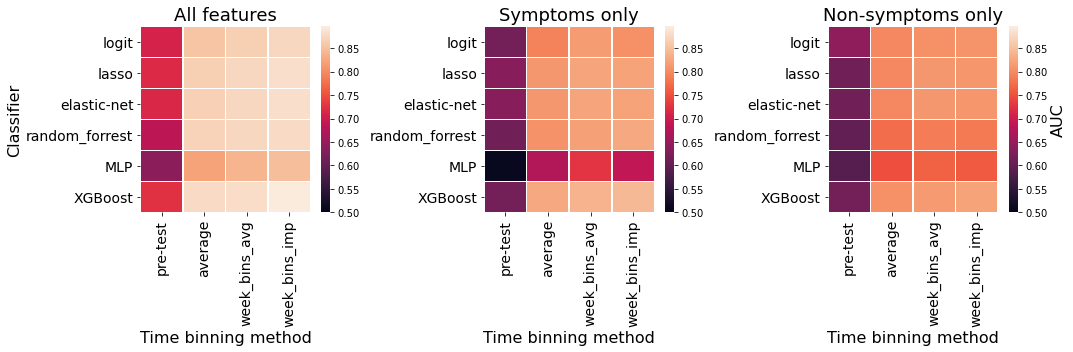


Full: best classifier is XGBoost_week_bins_imp with AUC = 0.9
Full: best pre-test classifier is XGBoost with AUC = 0.73

Symptoms: best classifier is XGBoost_week_bins_imp with AUC = 0.84
Symptoms: best pre-test classifier is elastic-net with AUC = 0.64

Non-symptoms: best classifier is XGBoost_week_bins_imp with AUC = 0.84
Non-symptoms: best pre-test classifier is logit with AUC = 0.64


In [332]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,5))
plt.axis('off')
max_auc = max([np.max(AUC_symptoms), np.max(AUC_full), np.max(AUC_non_symptoms)])

fig.add_subplot(1,3,1)
ax = sns.heatmap(AUC_full, linewidth=0.5, robust=True, yticklabels=models, #ax=ax,
            xticklabels=time_methods, vmin=0.5, vmax=max_auc)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time binning method', size=16)
plt.ylabel('Classifier', size=16)
plt.title('All features', size=18)

fig.add_subplot(1,3,2)
ax = sns.heatmap(AUC_symptoms, linewidth=0.5, robust=True, yticklabels=models, #ax=ax,
            xticklabels=time_methods, vmin=0.5, vmax=max_auc)
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time binning method', size=16)
plt.title('Symptoms only', size=18)

fig.add_subplot(1,3,3)
ax = sns.heatmap(AUC_non_symptoms, linewidth=0.5, robust=True, yticklabels=models, #ax=ax,
            xticklabels=time_methods, vmin=0.5, vmax=max_auc, cbar_kws={'label': "AUC"})
ax.figure.axes[-1].yaxis.label.set_size(16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Time binning method', size=16)
#plt.ylabel('Classifier', size=16)
plt.title('Non-symptoms only', size=18)

plt.tight_layout()
plt.show()

#time_methods = ['pre-test', 'average', 'week_bins_avg', 'week_bins_imp']
#models = ['logit', 'lasso', 'elastic-net', 'random_forrest', 'MLP']

ind = np.unravel_index(np.argmax(AUC_full, axis=None), AUC_full.shape)
mod_name = models[ind[0]]+'_'+time_methods[ind[1]]
print('\nFull: best classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_full),2)))
mod_name = models[np.argmax(AUC_full[:,0])]
print('Full: best pre-test classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_full[:,0]),2)))
ind = np.unravel_index(np.argmax(AUC_symptoms, axis=None), AUC_full.shape)
mod_name = models[ind[0]]+'_'+time_methods[ind[1]]
print('\nSymptoms: best classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_symptoms),2)))
mod_name = models[np.argmax(AUC_symptoms[:,0])]
print('Symptoms: best pre-test classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_symptoms[:,0]),2)))
ind = np.unravel_index(np.argmax(AUC_non_symptoms, axis=None), AUC_full.shape)
mod_name = models[ind[0]]+'_'+time_methods[ind[1]]
print('\nNon-symptoms: best classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_symptoms),2)))
mod_name = models[np.argmax(AUC_non_symptoms[:,0])]
print('Non-symptoms: best pre-test classifier is '+mod_name+' with AUC = '+str(np.round(np.max(AUC_symptoms[:,0]),2)))